In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "2" #set cores for numpy
import numpy as np
import tensorflow as tf
import json
tf.get_logger().setLevel('ERROR') #no info and warnings are printed 
tf.config.threading.set_inter_op_parallelism_threads(1) #set cores for TF
tf.config.threading.set_intra_op_parallelism_threads(1)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# tf.config.set_visible_devices([], 'GPU') #runs the code without GPU
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import time
from pathlib import Path
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from scipy.io import loadmat, savemat
from matplotlib.gridspec import *
plt.style.use('dark_background')

#Latex
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

#ESN functions
%run ./Functions.ipynb

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load data

In [2]:
upsample = 10     #upsample of the ESN
Re       = 30
data_len = 600000 #longer interval to include test set
transient = 10000

Nx = 48
Nu = 2
# Generate this from Gen_data.ipynb
fln = '/data/ar994/Python/data/Kolmogorov/Kolmogorov_0.1_48_30.0_100100_32.h5'
hf  = h5py.File(fln,'r')
dt  = 0.1*upsample
U   = np.array(hf.get('U')[transient:transient+data_len:upsample], dtype=np.float32)
hf.close()

print(U.shape)

(60000, 48, 48, 2)


## Autoencoder Functions

In [3]:
def model(inputs, enc_mods, dec_mods, is_train=False):
    
    '''
    Multiscale autoencoder, taken from Hasegawa 2020. The contribution of the CNNs at different
    scales are simply summed.
    '''
        
    # sum of the contributions of the different CNNs
    encoded = 0
    for enc_mod in enc_mods:
        encoded += enc_mod(inputs, training=is_train)
            
    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(encoded, training=is_train)
        
    return encoded, decoded

def decode(inputs, dec_mods, is_train=False):
    
    '''
    Multiscale decoder, taken from Hasegawa 2020. The contribution of the CNNs at different
    scales are simply summed.
    '''
            
    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(inputs, training=is_train)
        
    return decoded

class PerPad2D(tf.keras.layers.Layer):
    """
    Periodic Padding layer
    """
    def __init__(self, padding=1, asym=False, **kwargs):
        self.padding = padding
        self.asym    = asym
        super(PerPad2D, self).__init__(**kwargs)
        
    def get_config(self): #needed to be able to save and load the model with this layer
        config = super(PerPad2D, self).get_config()
        config.update({
            'padding': self.padding,
            'asym': self.asym,
        })
        return config

    def call(self, x):
        return periodic_padding(x, self.padding, self.asym)

def periodic_padding(image, padding=1, asym=False):
    '''
    Create a periodic padding (same of np.pad('wrap')) around the image, 
    to mimic periodic boundary conditions.
    When asym=True on the right and lower edges an additional column/row is added
    '''
        
    if asym:
        lower_pad = image[:,:padding+1,:]
    else:
        lower_pad = image[:,:padding,:]
    
    if padding != 0:
        upper_pad     = image[:,-padding:,:]
        partial_image = tf.concat([upper_pad, image, lower_pad], axis=1)
    else:
        partial_image = tf.concat([image, lower_pad], axis=1)
        
    if asym:
        right_pad = partial_image[:,:,:padding+1] 
    else:
        right_pad = partial_image[:,:,:padding]
    
    if padding != 0:
        left_pad = partial_image[:,:,-padding:]
        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=2)
    else:
        padded_image = tf.concat([partial_image, right_pad], axis=2)

    return padded_image

## Test autoencoder

NMAE:  0.0012634641
NMAE:  0.0013275477
NMAE:  0.0013610551
NMAE:  0.0012209793
NMAE:  0.0012618918


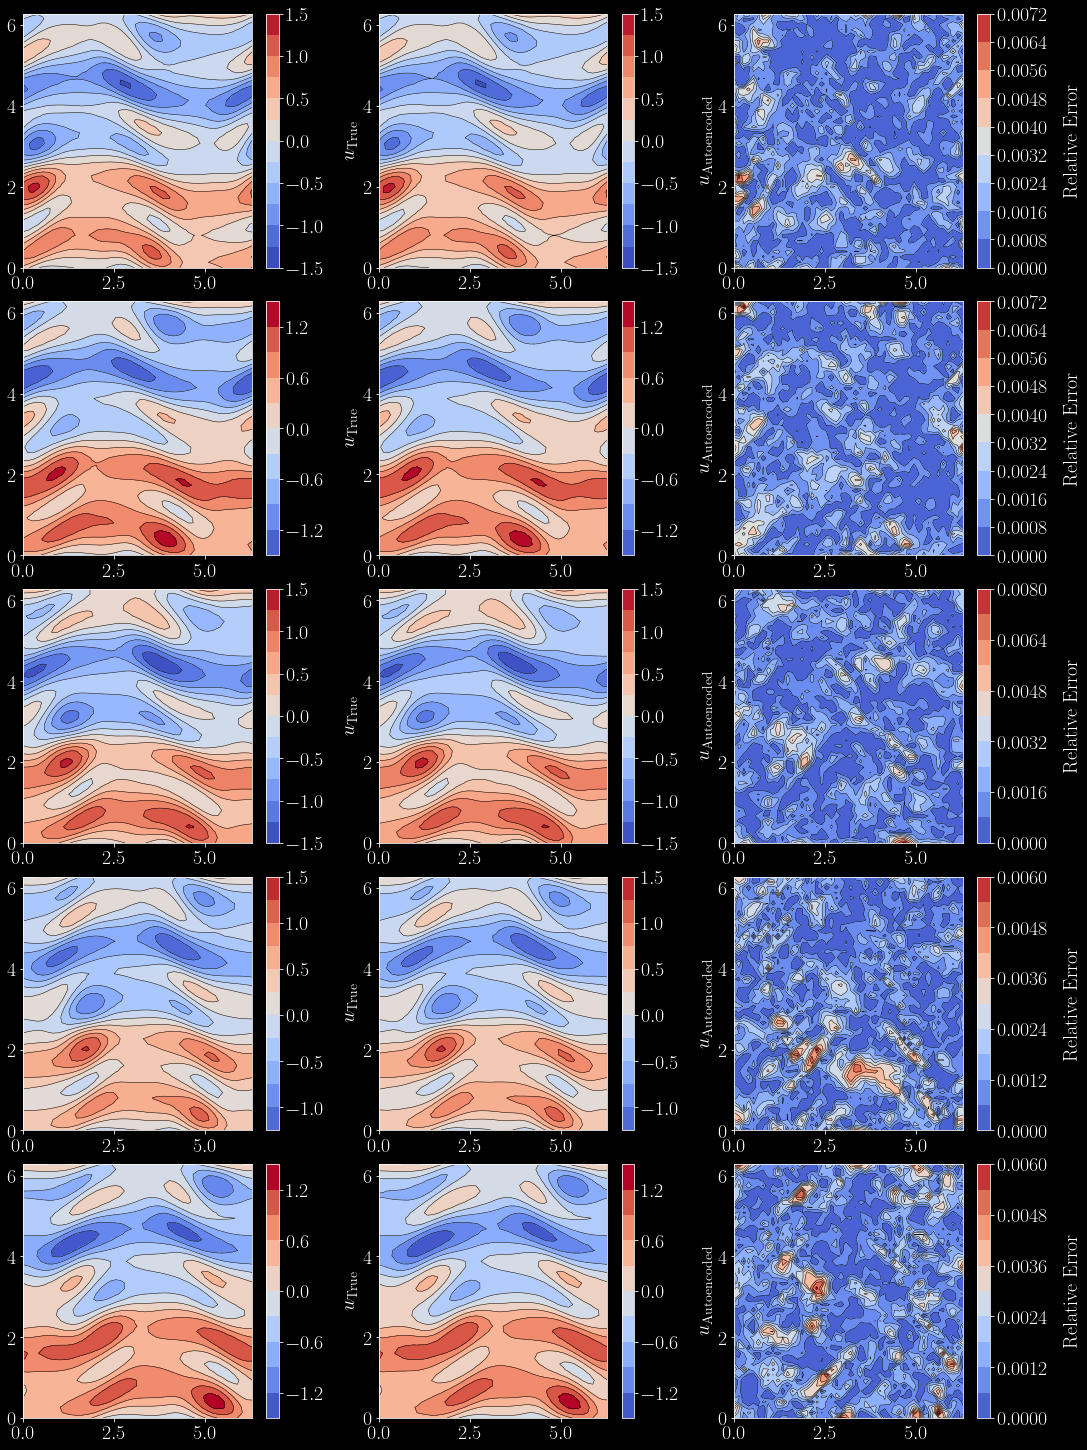

In [4]:
#plot flowfields

N_latent   = 18
N_parallel = 3
ker_size   = [(3,3),(5,5),(7,7)]

N_x = 48
N_y = 48
N_u = 2

#load model for the test set
path = './data/48_RE30_'+str(N_latent)
# Load best model
#how to load saved model
a = [None]*N_parallel
b = [None]*N_parallel
for i in range(N_parallel):
    a[i] = tf.keras.models.load_model(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5', 
                                          custom_objects={"PerPad2D": PerPad2D})
for i in range(N_parallel):
    b[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5',
                                          custom_objects={"PerPad2D": PerPad2D})

#grid
X       = np.linspace(0,2*np.pi,N_x) 
Y       = np.linspace(0,2*np.pi,N_y) 
XX      = np.meshgrid(X, Y, indexing='ij')

#plot n snapshots and their reconstruction in the test set.
n       = 5
plt.rcParams["figure.figsize"] = (15,4*n)
plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(n,3)

start   = 30000 #start after validation set

for i in range(n):
    
    #truth
    plt.subplot(n,3,i*3+1)
    
    skips = 50
    
    #snapshots to plot
    u      = U[start+500+i*skips:start+501+i*skips].copy()      
    vmax   = u.max()
    vmin   = u.min()

    CS0    = plt.contourf(XX[0], XX[1],u[0,:,:,0],
                          levels=10,cmap='coolwarm',vmin=vmin, vmax=vmax)
    cbar   = plt.colorbar()
    cbar.set_label('$u_{\mathrm{True}}$',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u[0,:,:,0],
                         levels=10,colors='black',linewidths=.5, linestyles='solid',
                         vmin=vmin, vmax=vmax)
    
    #autoencoded
    plt.subplot(n,3,i*3+2)

    u_dec  = model(u,a,b)[1][0].numpy()
    CS     = plt.contourf(XX[0],XX[1],u_dec[:,:,0],
                        levels=10,cmap='coolwarm',vmin=vmin, vmax=vmax)
    cbar   = plt.colorbar()
    cbar.set_label('$u_{\mathrm{Autoencoded}}$',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u_dec[:,:,0],
                         levels=10,colors='black',linewidths=.5, linestyles='solid',
                         vmin=vmin, vmax=vmax)
    
    #error
    plt.subplot(n,3,i*3+3)

    u_err  = np.abs(u_dec-u[0])/(vmax-vmin)
    print('NMAE: ', u_err[:,:,0].mean())

    CS     = plt.contourf(XX[0], XX[1],u_err[:,:,0],levels=10,cmap='coolwarm')
    cbar   = plt.colorbar()
    cbar.set_label('Relative Error',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u_err[:,:,0],levels=10,colors='black',linewidths=.5, 
                         linestyles='solid')

fig.tight_layout(pad=0.1)
plt.show()

In [5]:
## Compare POD with CAE

### POD
lenn           = 25
skip           = 4
POD_error      = np.zeros(lenn)

train_leng     = 30000
tr_data        = U[:train_leng].reshape(train_leng, N_x*N_y*N_u) #training data
test_data      = U[train_leng:].reshape(U.shape[0] - train_leng, N_x*N_y*N_u) #test data

for i in range(lenn):
    pca           = PCA(n_components=i*skip+1) #compute the POD loss every skip
    pca.fit(tr_data) #POD modes based on training data
    
    PCA_lat       = pca.transform(test_data)  #compress test data 
    PCA_back      = pca.inverse_transform(PCA_lat) #decompress test data
    
    POD_error[i]  = mean_squared_error(PCA_back,test_data) #error between the input and reconstructed with POD
    
### CAE
#reduce memory requirement on gpu, process only N_pos at a time
N_pos     = 5000 #split in k interval of N_pos length needed to process long timeseries
k         = (U.shape[0] - train_leng)//N_pos

U_dec = np.empty((k*N_pos, N_x, N_y, N_u))
for i in range(k):
    U_dec[i*N_pos:(i+1)*N_pos]  = model(U[train_leng:][i*N_pos:(i+1)*N_pos],a,b)[1]

CAE_error = mean_squared_error(U_dec.flatten(),U[train_leng:].flatten())

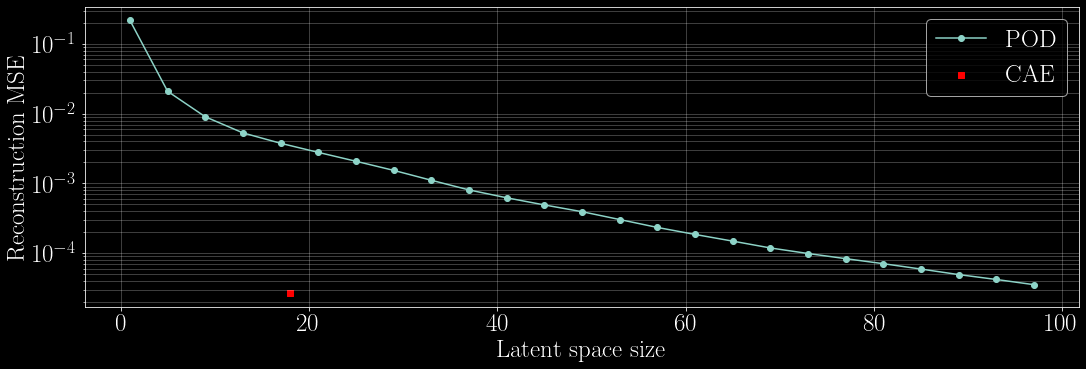

In [6]:
#plot error of POD and CAE
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25

plt.plot(np.arange(lenn)*skip+1,POD_error,marker='o',label='POD')
plt.scatter(N_latent, CAE_error, c='r',label='CAE',marker='s')

plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Latent space size')
plt.yscale('log')
plt.legend()
plt.tight_layout(pad=0.1)

## CAE-ESN prediction

In [7]:
def gradient(U,dx,dy):
    '''Computes the spatial derivatives of the flowfield'''
    
    shapes= U.shape
    dU_dx = np.empty(shapes)
    dU_dy = np.empty(shapes)
    
    for j in range(shapes[1]):
        dU_dx[:,j] = (U[:,(j+1)%shapes[1]] - U[:,j-1])/(2*dx)
    for k in range(shapes[2]):
        dU_dy[:,:,k] = (U[:,:,(k+1)%shapes[2]] - U[:,:,k-1])/(2*dy)
        
    return dU_dx, dU_dy

In [8]:
#Compute encoded time series for the ESN
N_pos     = 5000 #split in k interval of N_pos length needed to process long timeseries
k         = (U.shape[0] - train_leng)//N_pos

U_enc = np.empty((k*N_pos, N_latent))
for i in range(k):
    U_enc[i*N_pos:(i+1)*N_pos] = model(U[train_leng:][i*N_pos:(i+1)*N_pos],a,b)[0].numpy().reshape(N_pos,N_latent)

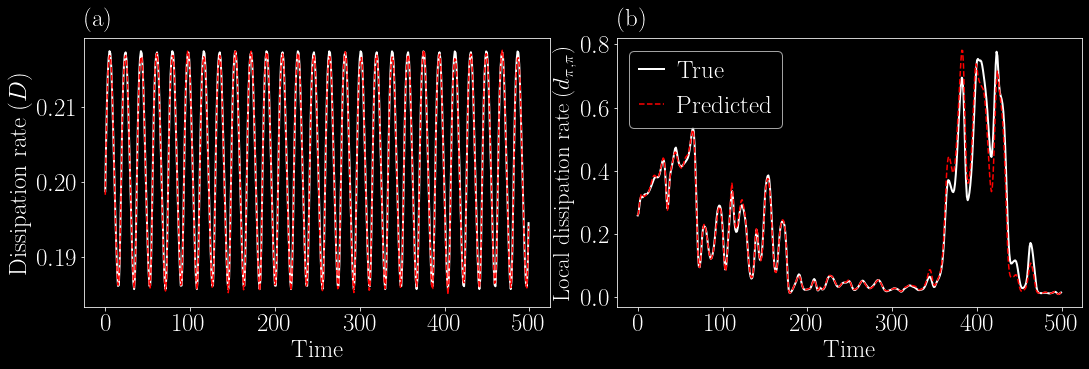

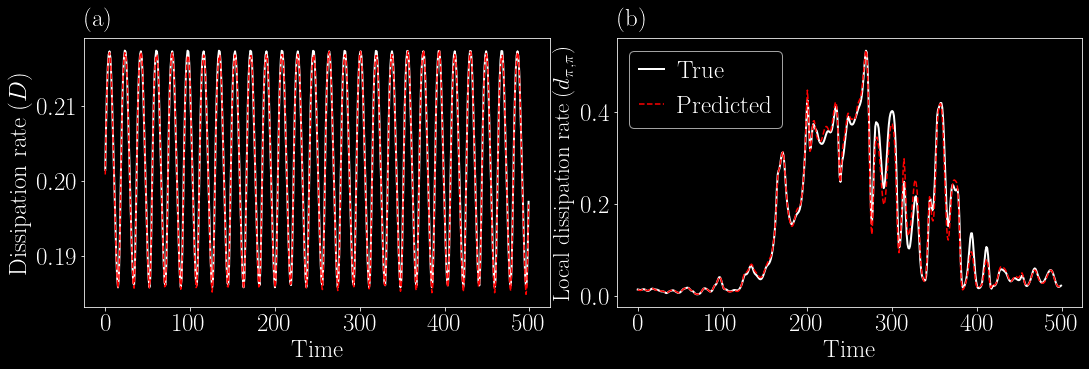

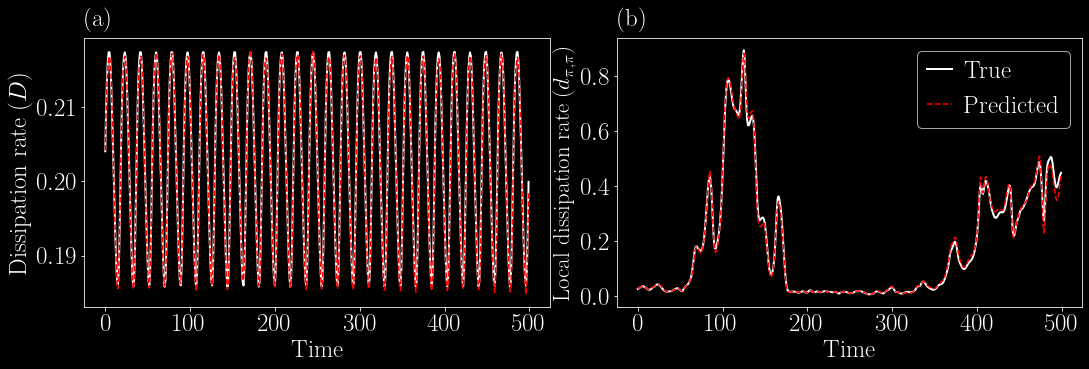

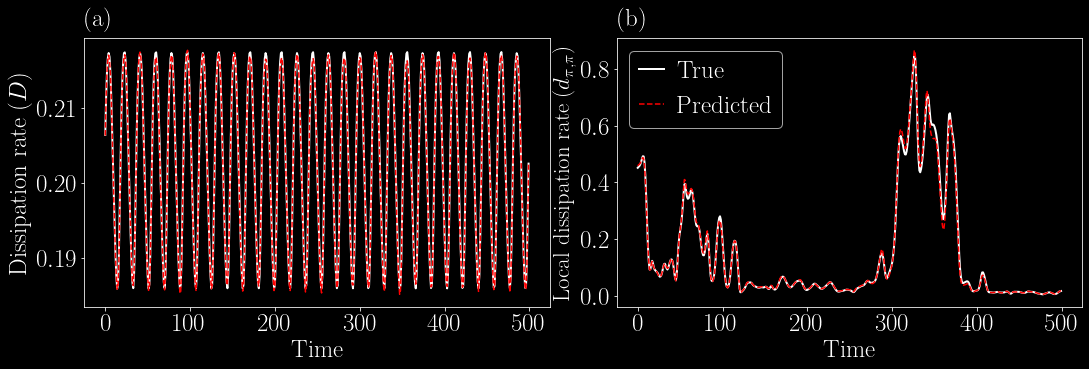

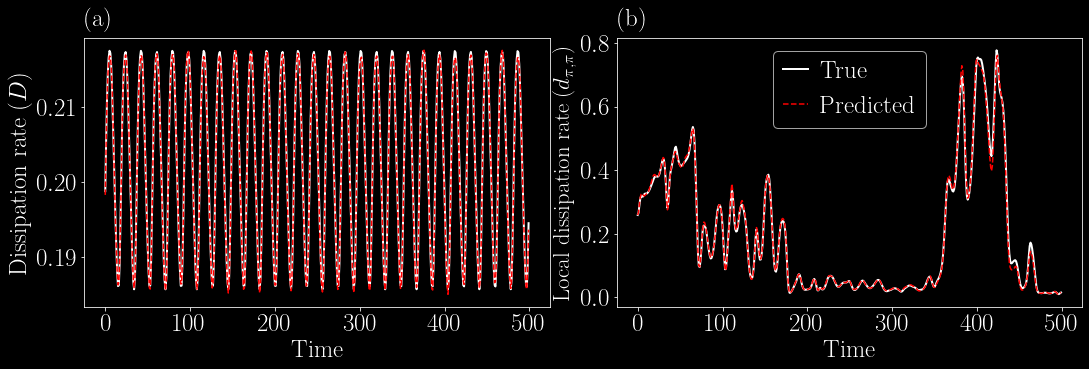

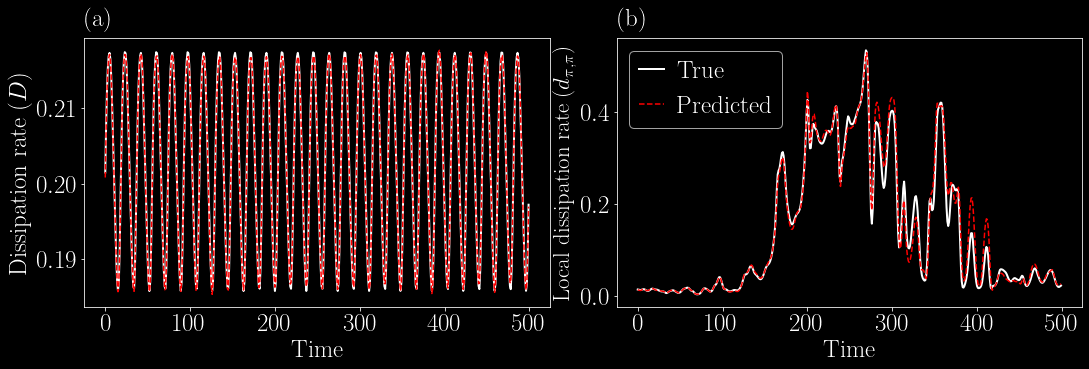

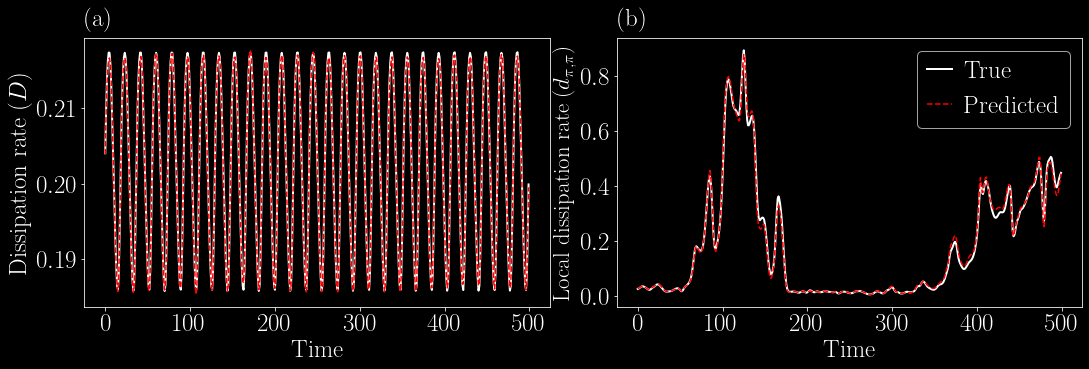

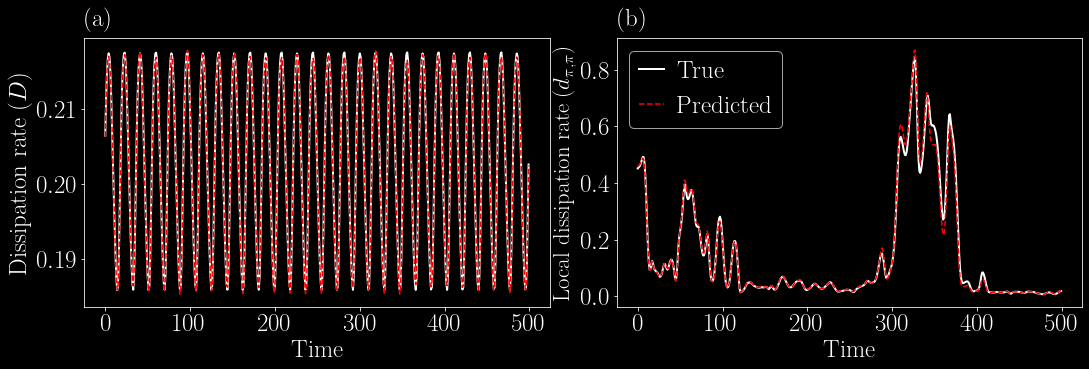

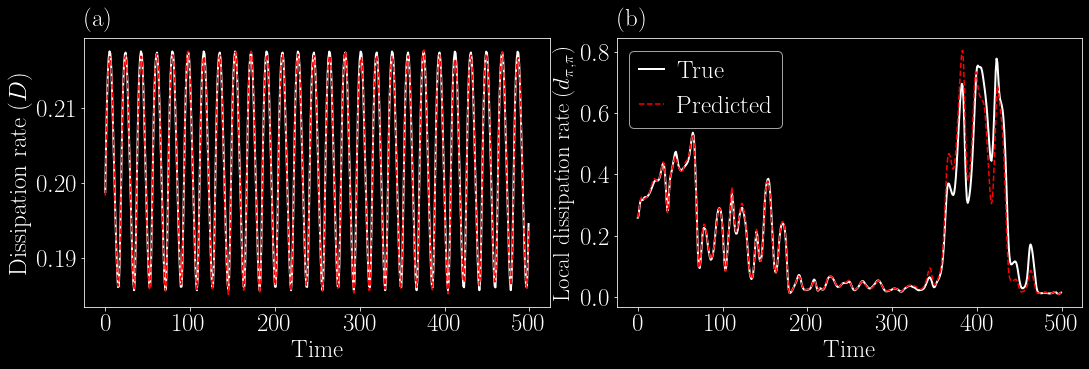

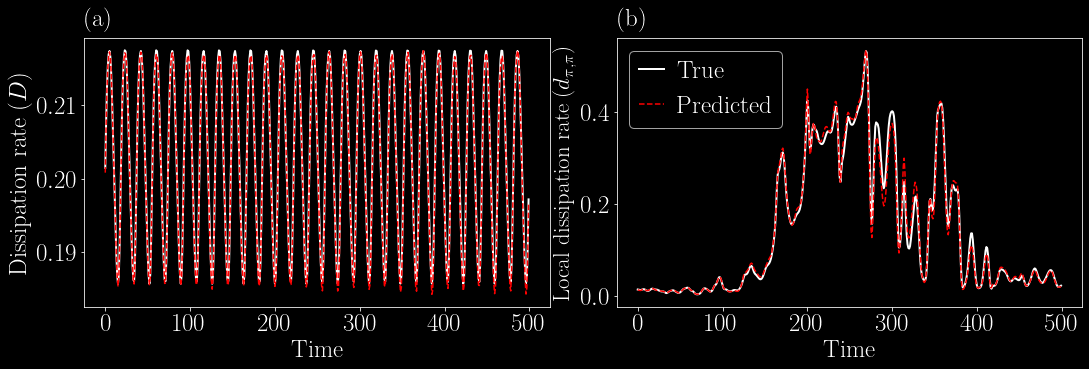

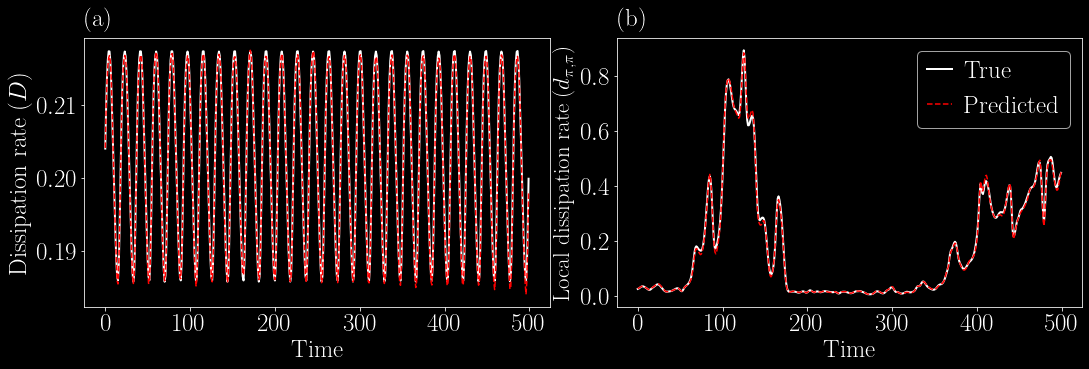

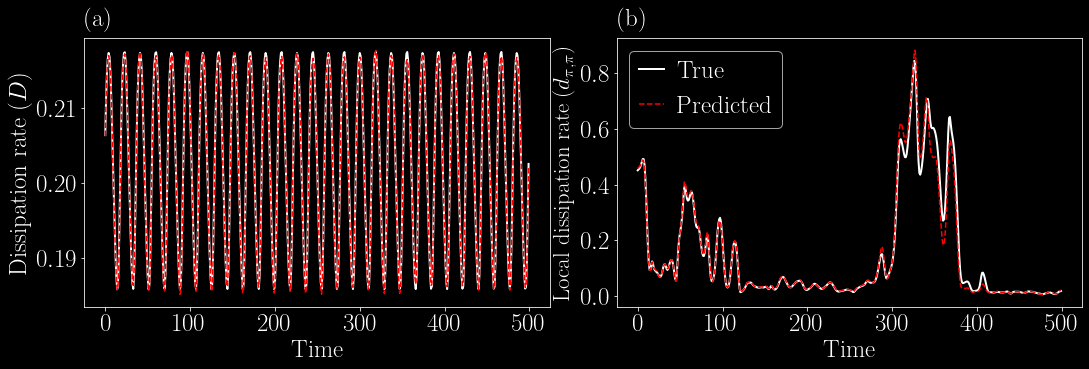

In [9]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25

#load ESN
N_units = 2000
data    = loadmat('./data/ESN_' + str(N_units) +'.mat')
ensemble = len(data['Win'][0])

N_test   = 50             #number of intervals in the test set
N_intt   = int(500/dt)    #length of each test set interval

plot   = True
n_plot = 4

MSEs = np.empty((ensemble, N_test)) #to store errors of the predictions

#different ESNs realization
for j in range(0,ensemble):
    
    # ESN matrices and hyperparameters from ESN.ipynb
    Win  = csr_matrix(data['Win'][0][j])
    W    = csr_matrix(data['W'][0][j])
    Wout = np.array(data['Wout'][j])                 
    norm, u_mean = data['norm']
    rho, sigma_in = data['opt_hyp'][j]
    bias_in, N_washout = data['fix_hyp'][0]
    bias_out  = np.array([1.]) 
    N_washout = int(N_washout)
    sigma_in = sigma_in
    rho  = rho
    dim  = N_latent
    
    N_start  = N_washout
    
    #different points in test set
    for i in range(N_test):
    
        # data for washout and target in each interval
        U_wash    = U_enc[N_start - N_washout +i*N_intt : N_start + i*N_intt].copy()
                
        #washout for each interval
        Xa1     = open_loop(U_wash, np.zeros(N_units), sigma_in, rho)
        Uh_wash = np.dot(Xa1, Wout)
                
        # Prediction
        Yh_t        = closed_loop(N_intt-1, Xa1[-1], Wout, sigma_in, rho)[0]
        Uh_t        = decode(Yh_t.reshape(N_intt,3,3,N_latent//9),b)
        
        U_t         = U[train_leng:][N_start + i*N_intt: N_start + i*N_intt + N_intt].copy()
        MSEs[j,i]   = mean_squared_error(Uh_t.numpy().flatten(),U_t.flatten())
                
        if plot and i<n_plot:
            dx        = 2*np.pi/(Nx-1)
            DUDX1     = gradient(U_t,dx,dx)
            DUDX2     = gradient(Uh_t,dx,dx)
            DD1       = np.mean(DUDX1[0]**2+DUDX1[1]**2,
                                axis=(1,2,3))/30*4
            DD2       = np.mean(DUDX2[0]**2+DUDX2[1]**2,
                                axis=(1,2,3))/30*4

            DL1       = np.mean(DUDX1[0][:,Nx//2,Nx//2]**2+DUDX1[1][:,Nx//2,Nx//2]**2,
                            axis=(1))/30*4
            DL2       = np.mean(DUDX2[0][:,Nx//2,Nx//2]**2+DUDX2[1][:,Nx//2,Nx//2]**2,
                            axis=(1))/30*4
            
            axx = plt.figure()
            gs = GridSpec(1, 2, figure=axx,
                          wspace=0.1,hspace=0.1)

            gss = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.], 
                                          subplot_spec=gs[1],
                                                 wspace=0.1)
            ax = axx.add_subplot(gs[0]) 
            plt.plot(DD1, 'w', label='True', lw=2)
            plt.plot(DD2, 'r--', label='Predicted')
            plt.ylabel('Dissipation rate $(D)$')
            plt.xlabel('Time')
            plt.annotate('(a)',
            (0.00, 1.02), xytext=(1, 1), va='bottom', ha='left',
            xycoords='axes fraction', textcoords='offset points')


            ax = axx.add_subplot(gs[1]) 
            plt.plot(DL1, 'w', label='True', lw=2)
            plt.plot(DL2, 'r--', label='Predicted')
            plt.ylabel('Local dissipation rate $(d_{\pi,\pi})$',fontsize=23)
            plt.xlabel('Time')
            plt.annotate('(b)',
            (0.00, 1.02), xytext=(1, 1), va='bottom', ha='left',
            xycoords='axes fraction', textcoords='offset points')
            plt.legend(handlelength=1.,handletextpad=0.5)
            gs.tight_layout(axx,pad=0.1,h_pad=.5)
            
            plt.show()

In [17]:
print('Average MSE per realization:', 10**np.mean(np.log10(MSEs),axis=1))
print('25th, 50th, and 75th MSE per realization:', 
      np.quantile(MSEs,.25,axis=1), np.median(MSEs,axis=1),np.quantile(MSEs,.75,axis=1))

Average MSE per realization: [0.00101181 0.0012375  0.00122311]
25th, 50th, and 75th MSE per realization: [0.00042034 0.00038734 0.00048681] [0.00107963 0.00112395 0.00110477] [0.00336915 0.00360433 0.00582124]
